<a href="https://colab.research.google.com/github/andres-merino/AprendizajeAutomaticoInicial-05-N0105/blob/main/2-Ejercicios/07-Perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table style="border: none; border-collapse: collapse;">
    <tr>
        <td style="width: 20%; vertical-align: middle; padding-right: 10px;">
            <img src="https://i.imgur.com/nt7hloA.png" width="100">
        </td>
        <td style="width: 2px; text-align: center;">
            <font color="#0030A1" size="7">|</font><br>
            <font color="#0030A1" size="7">|</font>
        </td>
        <td>
            <p style="font-variant: small-caps;"><font color="#0030A1" size="5">
                <b>Facultad de Ciencias Exactas, Naturales y Ambientales</b>
            </font> </p>
            <p style="font-variant: small-caps;"><font color="#0030A1" size="4">
                Aprendizaje Automático Inicial &bull; Perceptrón
            </font></p>
            <p style="font-style: oblique;"><font color="#0030A1" size="3">
                Andrés Merino
            </font></p>
            </font></p>
            <p style="font-style: oblique;"><font color="#0030A1" size="3">
                Ignacio Zambrano &bull; 13-01-2026
            </font></p>
        </td>  
    </tr>
</table>

---
## <font color='264CC7'> Introducción </font>

A lo largo de este taller, aplicaremos un perceptrón para clasificar un conjunto de datos.

Los paquetes necesarios son:

In [2]:
# Paquetes necesarios
from sklearn.datasets import fetch_openml
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical


**Fijar semilla**

In [3]:
# Fijar las semillas para reproducibilidad
import random
import os

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.config.experimental.enable_op_determinism()
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
    os.environ["TF_DETERMINISTIC_OPS"] = "1"

set_seed(42)


---
## <font color='264CC7'> Clasificación </font>

Se usará el conjunto de datos de dígitos de MNIST.

In [4]:
# Cargamos el dataset MNIST
X, y = fetch_openml('mnist_784', return_X_y=True, parser='auto')

# Convertimos a numpy
X = X.to_numpy()
y = y.to_numpy()

# Convertimos etiquetas a enteros (IMPORTANTE)
y = y.astype(int)



### <font color='264CC7'> Preprocesamiento de datos </font>

Primero necesitas el conjunto de datos. Los datos a utilzar son los seleccionados en la clase anterior.

<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
    Carga el conjunto de datos y procésalos:
<ul>
  <li>Muestra algunos datos.</li>
  <li>Muestra una descripción de los datos.</li>
  <li>Escala los datos si es necesario.</li>
</ul>
</div>

**Visualización de algunos datos**

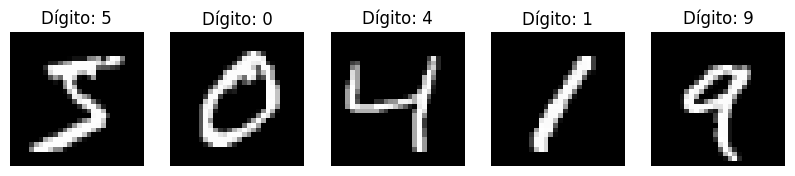

In [5]:
fig, axes = plt.subplots(1, 5, figsize=(10, 3))

for i, ax in enumerate(axes):
    img = X[i].reshape(28, 28)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Dígito: {y[i]}")
    ax.axis('off')

plt.show()


**Mostrar una descripción de los datos**

In [6]:
df_X = pd.DataFrame(X)
df_y = pd.Series(y, name="Etiqueta")


Dimensiones del dataset

In [7]:
print("Dimensión de X:", X.shape)
print("Dimensión de y:", y.shape)


Dimensión de X: (70000, 784)
Dimensión de y: (70000,)


Estadísticas básicas

In [8]:
df_X.describe()


,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
count,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,...,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.0,70000.0,70000.0,70000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.197414,0.099543,0.046629,0.016614,0.012957,0.001714,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.991206,4.256304,2.783732,1.561822,1.553796,0.320889,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.000000,254.000000,62.000000,0.0,0.0,0.0,0.0


Distribución de clases

In [9]:
df_y.value_counts().sort_index()


,count
Etiqueta,
0,6903
1,7877
2,6990
3,7141
4,6824
5,6313
6,6876
7,7293
8,6825


**Preprocesamiento: Escalado de datos**

In [10]:
# Normalización de los píxeles
X = X / 255.0



### <font color='264CC7'> Determinación de la red </font>

<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
    Determina una red neuronal para clasificar los datos:
<ul>
  <li>Define la red.</li>
  <li>Compila la red.</li>
  <li>Presenta un resumen de la red.</li>
</ul>
</div>


División en entrenamiento y prueba

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


Codificación one-hot de las etiquetas

In [12]:
y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)


**Definición de la red neuronal**

In [13]:
model = Sequential([
    Input(shape=(784,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax')
])


**Compilación del modelo**

In [14]:
optimizer = SGD(learning_rate=0.1)
loss = CategoricalCrossentropy()

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
)


**Resumen del modelo**

In [15]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,650 (205.66 KB)

 Trainable params: 52,650 (205.66 KB)

 Non-trainable params: 0 (0.00 B)


### <font color='264CC7'> Entrenamiento del modelo y evaluación </font>


<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
    Entrena el modelo y evalúalo:
<ul>
  <li>Entrena el modelo.</li>
  <li>Evalúa el modelo con el conjunto de datos de prueba.</li>
  <li>Genera una matriz de confusión y muestra las métricas de evaluación.</li>
</ul>
</div>

**Entrenamiento del modelo**

In [16]:
history = model.fit(
    X_train,
    y_train_cat,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


Epoch 1/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8361 - loss: 0.5454 - val_accuracy: 0.9477 - val_loss: 0.1719
Epoch 2/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9530 - loss: 0.1576 - val_accuracy: 0.9604 - val_loss: 0.1331
Epoch 3/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9681 - loss: 0.1093 - val_accuracy: 0.9632 - val_loss: 0.1194
Epoch 4/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9742 - loss: 0.0845 - val_accuracy: 0.9639 - val_loss: 0.1155
Epoch 5/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9791 - loss: 0.0681 - val_accuracy: 0.9645 - val_loss: 0.1119
Epoch 6/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9838 - loss: 0.0554 - val_accuracy: 0.9648 - val_loss: 0.1139
Epoch 7/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9862 - loss: 0.0467 - val_accuracy: 0.9661 - val_loss: 0.1160
Epoch 8/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9896 - loss: 0.0387 - 

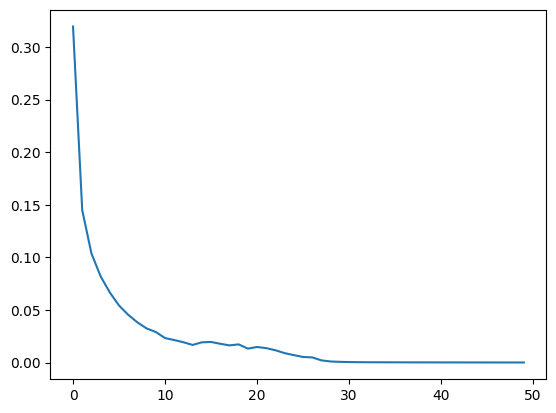

In [17]:
# Visualizar la pérdida
plt.plot(history.history['loss'])

**Evaluación del modelo**

Precisión y pérdida

In [18]:
loss, accuracy = model.evaluate(X_test, y_test_cat, verbose=0)

print(f"Loss en test: {loss:.4f}")
print(f"Accuracy en test: {accuracy:.4f}")


Loss en test: 0.1562
Accuracy en test: 0.9766


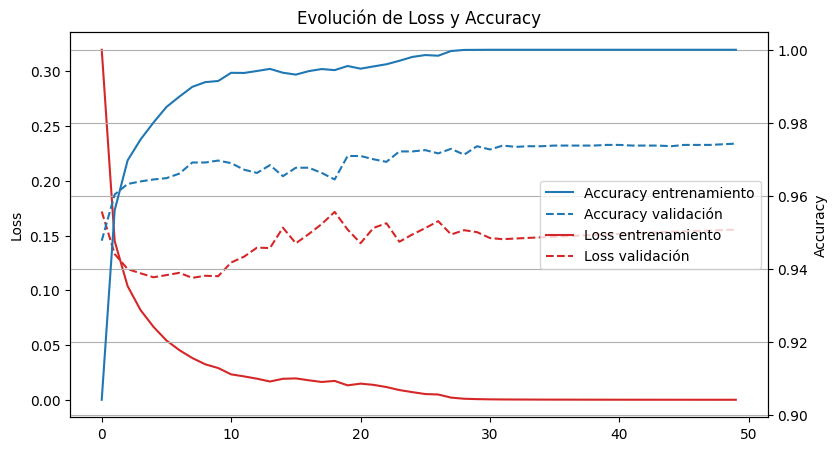

In [23]:
plt.figure(figsize=(9, 5))

# Eje izquierdo: Loss
plt.plot(history.history['loss'], label='Loss entrenamiento', color='tab:red')
plt.plot(history.history['val_loss'], label='Loss validación', linestyle='--', color='tab:red')
plt.ylabel('Loss')

# Eje derecho: Accuracy
plt.twinx()
plt.plot(history.history['accuracy'], label='Accuracy entrenamiento', color='tab:blue')
plt.plot(history.history['val_accuracy'], label='Accuracy validación', linestyle='--', color='tab:blue')
plt.ylabel('Accuracy')

plt.xlabel('Épocas')
plt.title('Evolución de Loss y Accuracy')
plt.grid(True)

# Truco para mostrar todas las leyendas juntas
lines, labels = plt.gca().get_legend_handles_labels()
lines2, labels2 = plt.gcf().axes[0].get_legend_handles_labels()
plt.legend(lines + lines2, labels + labels2, loc='center right')

plt.show()


Predicciones

In [19]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)


438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Matriz de confusión

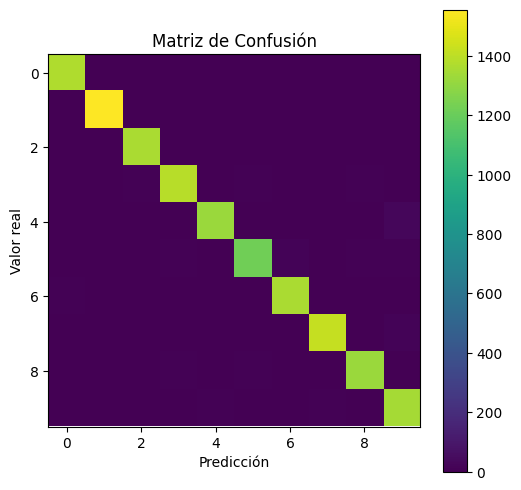

In [20]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
plt.imshow(cm)
plt.title("Matriz de Confusión")
plt.colorbar()
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.show()


Reporte de clasificación

In [21]:
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1381
           1       0.99      0.99      0.99      1575
           2       0.98      0.97      0.98      1398
           3       0.98      0.97      0.97      1428
           4       0.98      0.97      0.97      1365
           5       0.98      0.97      0.97      1263
           6       0.98      0.99      0.98      1375
           7       0.98      0.97      0.98      1459
           8       0.97      0.97      0.97      1365
           9       0.96      0.97      0.96      1391

    accuracy                           0.98     14000
   macro avg       0.98      0.98      0.98     14000
weighted avg       0.98      0.98      0.98     14000



**Prueba de otros hiperparámetros**

Menor learning rate

In [22]:
model_lr = Sequential([
    Input(shape=(784,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax')
])

optimizer_lr = SGD(learning_rate=0.01)

model_lr.compile(
    optimizer=optimizer_lr,
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

history_lr = model_lr.fit(
    X_train,
    y_train_cat,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=0
)

loss_lr, acc_lr = model_lr.evaluate(X_test, y_test_cat, verbose=0)
print("Accuracy con learning rate 0.01:", round(acc_lr, 4))


Accuracy con learning rate 0.01: 0.9641


Más neuronas

In [24]:
model_big = Sequential([
    Input(shape=(784,)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

optimizer_big = SGD(learning_rate=0.1)

model_big.compile(
    optimizer=optimizer_big,
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

history_big = model_big.fit(
    X_train,
    y_train_cat,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=0
)

loss_big, acc_big = model_big.evaluate(X_test, y_test_cat, verbose=0)
print("Accuracy con más neuronas:", round(acc_big, 4))


Accuracy con más neuronas: 0.9786


Menos épocas

In [25]:
model_few = Sequential([
    Input(shape=(784,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax')
])

model_few.compile(
    optimizer=SGD(learning_rate=0.1),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

history_few = model_few.fit(
    X_train,
    y_train_cat,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    verbose=0
)

loss_few, acc_few = model_few.evaluate(X_test, y_test_cat, verbose=0)
print("Accuracy con 10 épocas:", round(acc_few, 4))


Accuracy con 10 épocas: 0.9695
